In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az
import scipy.stats as sps
import requests

sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/years-lost-life
# https://data.oecd.org/healthstat/potential-years-of-life-lost.htm

#### DEPENDS ON RUNNING stratified...ipynb to produce pkl-files below ###

In [3]:
strata_abs_deaths = pd.read_pickle('strata_abs_deaths.pkl')
strata_abs_deaths

,64,79,89,90+
year,,,,
2001,13260,27435,36600,16445
2002,13098,26994,37507,17383
2003,13085,26097,36751,17018
2004,13057,24865,35692,16910
2005,13095,24758,36190,17654
2006,13033,24041,36080,17999
2007,12937,23763,36350,18666
2008,12848,23500,36200,18886
2009,12554,23450,35430,18618


In [4]:
strata_abs_pop = pd.read_pickle('strata_abs_pop.pkl')
strata_abs_pop

,64,79,89,90+
year,,,,
2001,7364484.5,1073089.0,392306.5,66080.0
2002,7392028.5,1066061.0,399119.5,67749.0
2003,7420704.5,1064792.5,403221.5,69510.5
2004,7445736.5,1068657.0,407459.5,71678.0
2005,7469716.0,1075106.0,411296.0,73454.0
2006,7507097.5,1084698.5,413877.0,74831.5
2007,7553167.0,1104317.0,414345.5,76262.5
2008,7592890.0,1134709.5,414587.5,77450.0
2009,7630585.5,1174180.0,414772.5,78976.5


In [5]:
death_rate = strata_abs_deaths.div(strata_abs_pop ,axis=0)
death_rate

,64,79,89,90+
year,,,,
2001,0.001801,0.025566,0.093294,0.248865
2002,0.001772,0.025321,0.093974,0.256579
2003,0.001763,0.024509,0.091143,0.244826
2004,0.001754,0.023268,0.087596,0.235916
2005,0.001753,0.023028,0.087990,0.240341
2006,0.001736,0.022164,0.087176,0.240527
2007,0.001713,0.021518,0.087729,0.244760
2008,0.001692,0.020710,0.087316,0.243848
2009,0.001645,0.019971,0.085420,0.235741


In [6]:
std_pop = strata_abs_pop.loc[2010]
std_pop

64     7664114.5
79     1218367.0
89      412782.5
90+      82862.0
Name: 2010, dtype: float64

In [7]:
# age adjusted deaths, std year = 2010

age_adjusted_deaths = death_rate * std_pop
age_adjusted_deaths

,64,79,89,90+
year,,,,
2001,13799.493810,31149.232398,38510.296159,20621.452633
2002,13580.111565,30850.578717,38790.971695,21260.684970
2003,13514.207207,29860.957510,37622.422558,20286.798628
2004,13439.952250,28348.380682,36158.275829,19548.486565
2005,13435.795869,28057.075475,36320.797370,19915.127127
2006,13305.595708,27003.596895,35984.586242,19930.552481
2007,13127.029931,26217.159585,36212.880012,20281.292798
2008,12968.519641,25232.559082,36042.395152,20205.703447
2009,12609.162617,24332.475557,35260.013562,19533.971700


In [8]:
# OECD defines 74 as std death age

median_age_of_death = 70

age_grps = np.array([64,79,89,90])

lyl = median_age_of_death - age_grps
lyl

array([  6,  -9, -19, -20])

In [9]:
life_years_lost_per_age = age_adjusted_deaths * lyl
life_years_lost_per_age

,64,79,89,90+
year,,,,
2001,82796.962859,-280343.091584,-731695.627016,-412429.052663
2002,81480.669389,-277655.208456,-737028.462209,-425213.699390
2003,81085.243240,-268748.617586,-714826.028603,-405735.972551
2004,80639.713500,-255135.426142,-687007.240744,-390969.731298
2005,80614.775216,-252513.679278,-690095.150026,-398302.542544
2006,79833.574250,-243032.372058,-683707.138594,-398611.049625
2007,78762.179589,-235954.436262,-688044.720227,-405625.855958
2008,77811.117845,-227093.031741,-684805.507884,-404114.068948
2009,75654.975702,-218992.280017,-669940.257671,-390679.434009


In [10]:
life_years_lost_per_age = life_years_lost_per_age.applymap(lambda x : 0 if x < 0 else x)
life_years_lost_per_age

,64,79,89,90+
year,,,,
2001,82796.962859,0,0,0
2002,81480.669389,0,0,0
2003,81085.243240,0,0,0
2004,80639.713500,0,0,0
2005,80614.775216,0,0,0
2006,79833.574250,0,0,0
2007,78762.179589,0,0,0
2008,77811.117845,0,0,0
2009,75654.975702,0,0,0


In [11]:
LYL_total = life_years_lost_per_age.sum(axis=1)
LYL_total

year
2001    82796.962859
2002    81480.669389
2003    81085.243240
2004    80639.713500
2005    80614.775216
2006    79833.574250
2007    78762.179589
2008    77811.117845
2009    75654.975702
2010    72918.000000
2011    69895.836875
2012    68277.397340
2013    67385.689583
2014    65191.826745
2015    64146.084399
2016    62735.458847
2017    61153.700883
2018    59793.793847
2019    56656.908143
2020    57980.142203
dtype: float64

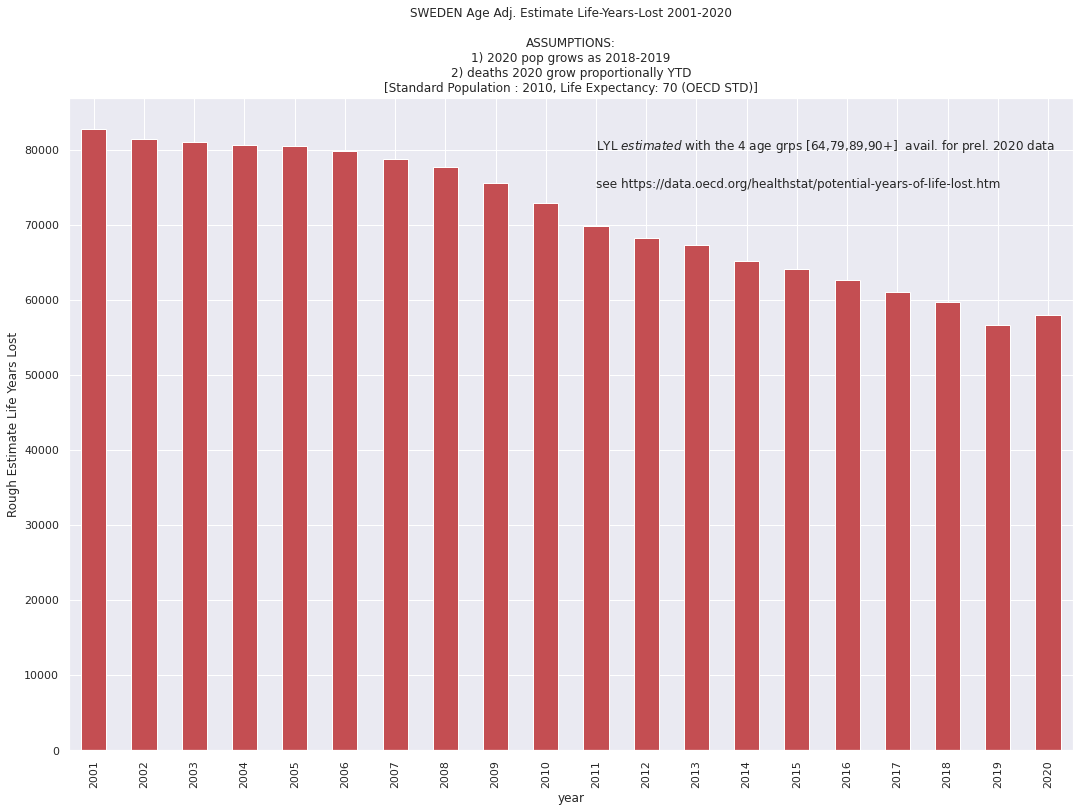

In [12]:
LYL_total.plot(kind='bar',
               figsize=(18,12),
               title='SWEDEN Age Adj. Estimate Life-Years-Lost 2001-2020\n\nASSUMPTIONS:\n1) 2020 pop grows as 2018-2019\n' \
               '2) deaths 2020 grow proportionally YTD\n[Standard Population : 2010, Life Expectancy: {} (OECD STD)]'.format(
                   median_age_of_death),
               color='r')

text = r'LYL $estimated$ with the 4 age grps [64,79,89,90+]  avail. for prel. 2020 data' 
text2 = 'see https://data.oecd.org/healthstat/potential-years-of-life-lost.htm'

plt.ylabel('Rough Estimate Life Years Lost')

plt.text(10,80000,text)
plt.text(10,75000,text2)

plt.savefig('LYL_{}.jpg'.format(median_age_of_death),format='jpg',dpi=400)

In [13]:
LYL_total_per_m = LYL_total / (std_pop.sum() / 1e6)
LYL_total_per_m

year
2001    8828.732186
2002    8688.374350
2003    8646.209620
2004    8598.702289
2005    8596.043092
2006    8512.742764
2007    8398.498761
2008    8297.085990
2009    8067.174156
2010    7775.327395
2011    7453.070781
2012    7280.494775
2013    7185.410985
2014    6951.476952
2015    6839.968284
2016    6689.551713
2017    6520.887103
2018    6375.878704
2019    6041.389094
2020    6182.487013
dtype: float64

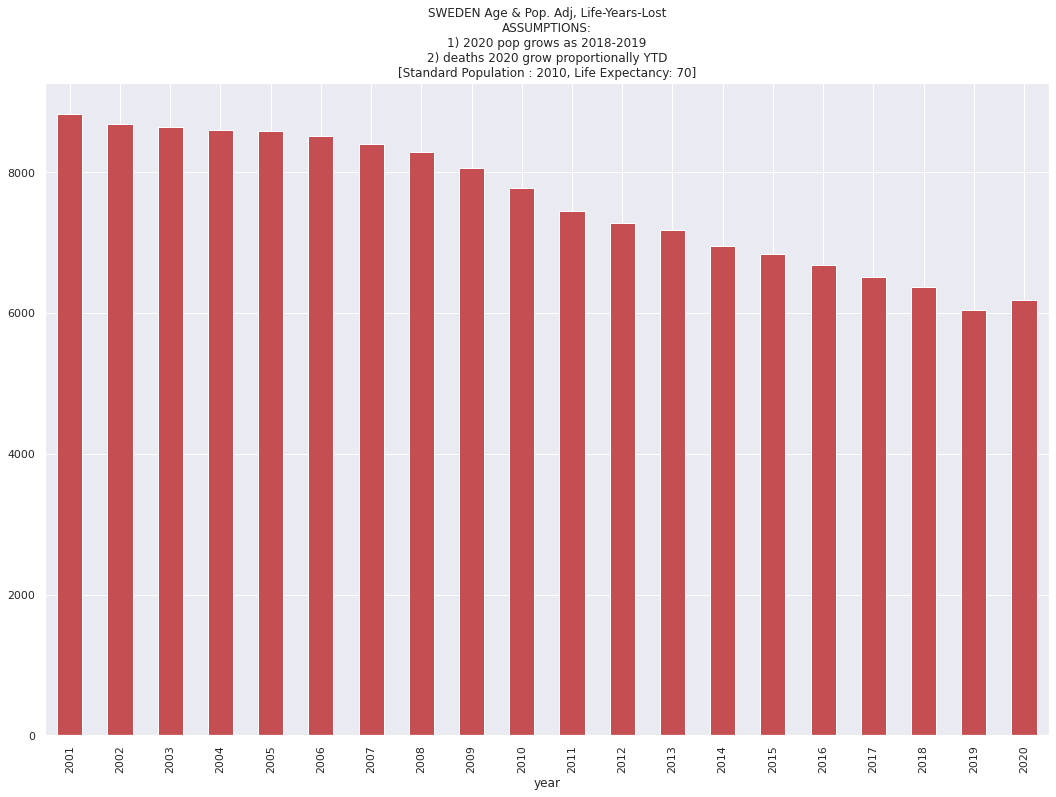

In [14]:
LYL_total_per_m.plot(kind='bar',
               figsize=(18,12),
               title='SWEDEN Age & Pop. Adj, Life-Years-Lost\nASSUMPTIONS:\n1) 2020 pop grows as 2018-2019\n' \
               '2) deaths 2020 grow proportionally YTD\n[Standard Population : 2010, Life Expectancy: {}]'.format(
                   median_age_of_death),
               color='r')

plt.savefig('LYL_per_m_{}.jpg'.format(median_age_of_death),format='jpg',dpi=400)

In [15]:
# constructed example using official SCB mortality data

scb_mortality = pd.read_pickle('mortality.pkl')
scb_mortality

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0.00365,0.00327,0.00311,0.00311,0.00243,0.00280,0.00249,0.00249,0.00249,0.00254,0.00210,0.00259,0.00269,0.00218,0.00245,0.00249,0.00241,0.00203,0.00207
1-4,0.00019,0.00019,0.00020,0.00013,0.00021,0.00017,0.00017,0.00014,0.00020,0.00015,0.00013,0.00013,0.00011,0.00011,0.00013,0.00013,0.00010,0.00014,0.00012
5-9,0.00009,0.00007,0.00009,0.00009,0.00010,0.00009,0.00009,0.00006,0.00009,0.00006,0.00009,0.00007,0.00006,0.00007,0.00007,0.00008,0.00006,0.00005,0.00005
10-14,0.00012,0.00011,0.00010,0.00010,0.00010,0.00009,0.00008,0.00011,0.00011,0.00009,0.00009,0.00010,0.00008,0.00007,0.00011,0.00008,0.00009,0.00011,0.00007
15-19,0.00030,0.00033,0.00034,0.00032,0.00026,0.00031,0.00032,0.00029,0.00027,0.00027,0.00028,0.00024,0.00024,0.00024,0.00023,0.00020,0.00024,0.00025,0.00024
20-24,0.00052,0.00053,0.00048,0.00055,0.00047,0.00050,0.00047,0.00048,0.00045,0.00046,0.00044,0.00043,0.00043,0.00045,0.00046,0.00038,0.00043,0.00048,0.00045
25-29,0.00046,0.00045,0.00047,0.00048,0.00050,0.00043,0.00050,0.00053,0.00047,0.00050,0.00049,0.00048,0.00054,0.00049,0.00055,0.00050,0.00055,0.00050,0.00047
30-34,0.00056,0.00055,0.00050,0.00048,0.00049,0.00050,0.00048,0.00054,0.00048,0.00050,0.00053,0.00049,0.00052,0.00062,0.00055,0.00058,0.00055,0.00055,0.00050
35-39,0.00081,0.00072,0.00074,0.00069,0.00070,0.00070,0.00068,0.00063,0.00069,0.00057,0.00062,0.00067,0.00065,0.00056,0.00061,0.00065,0.00064,0.00062,0.00063
40-44,0.00123,0.00121,0.00122,0.00111,0.00109,0.00107,0.00106,0.00107,0.00102,0.00091,0.00091,0.00088,0.00088,0.00092,0.00085,0.00089,0.00090,0.00087,0.00086


In [16]:
scb_population = pd.read_pickle('population.pkl')
scb_population

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,90953.5,93640.5,97486.0,100042.5,101137.0,103629.5,106667.0,108361.0,110551.0,113721.0,113705.5,112473.5,113385.0,114250.0,114888.5,116147.5,116420.5,115624.0,115177.5,113875.5
1-4,365855.0,365492.5,370206.5,379179.5,389814.5,400834.5,412277.0,422782.5,432051.0,441284.0,450873.0,458002.5,462916.0,467338.0,470299.0,475482.0,483122.0,487647.0,487930.5,486461.5
5-9,571656.0,542218.0,514317.5,490759.0,474303.0,468354.0,472129.5,482486.5,496334.5,509795.5,523297.0,537465.0,550971.5,564782.0,580366.0,594985.5,606516.5,615826.5,621778.5,626406.5
10-14,597072.0,614749.0,623447.5,621304.5,606924.0,582363.5,554586.5,528437.5,506985.5,492400.0,486739.0,490123.5,501707.5,517697.0,534034.5,552453.5,571776.5,588105.5,602388.5,615797.0
15-19,513820.5,525643.5,542763.0,563998.5,586538.5,609051.0,628375.0,639218.0,639970.5,628569.0,605490.5,578501.5,554127.0,535431.5,524854.0,526042.0,537225.0,552175.5,564211.0,573685.5
20-24,516177.5,516318.5,518510.5,521164.5,524790.0,534422.5,549551.5,568930.5,592894.0,618734.5,641439.0,659007.5,669546.5,671734.5,663988.5,648313.5,628549.0,607256.0,592646.0,582833.5
25-29,586539.0,574834.0,562349.5,550835.0,544890.0,545897.5,551093.0,558670.5,567324.0,576841.0,588529.5,602098.0,620157.5,643505.0,669084.0,697050.0,722845.0,737662.5,740509.0,738884.5
30-34,623457.0,615367.5,610357.0,610870.0,611456.5,606160.5,597623.0,589219.0,582653.0,580969.0,583490.0,588299.0,595738.0,604683.5,614224.5,630123.5,651834.5,676317.0,703016.0,729246.0
35-39,641582.0,657997.0,665407.0,658524.0,644583.5,634731.0,628969.5,626601.5,630604.5,634190.0,629915.0,621362.5,612844.5,606640.0,606469.0,612943.5,622755.0,634156.0,645358.5,655923.0
40-44,583888.5,584782.0,591458.5,606166.0,625964.5,646213.0,663974.5,672968.5,668655.0,657643.0,648969.5,643204.5,640947.5,645656.5,651029.0,649880.0,644745.5,638755.5,633549.5,628992.5


In [17]:
standard_population = scb_population[2010]
standard_population

0        113721.0
1-4      441284.0
5-9      509795.5
10-14    492400.0
15-19    628569.0
20-24    618734.5
25-29    576841.0
30-34    580969.0
35-39    634190.0
40-44    657643.0
45-49    631836.5
50-54    584934.5
55-59    573396.5
60-64    619800.0
65-69    530721.0
70-74    384094.5
75-79    303551.5
80-84    245948.0
85-89    166834.5
90+       82862.0
Name: 2010, dtype: float64

In [18]:
standard_deaths_age_grp = scb_mortality.mul(standard_population,axis=0)
standard_deaths_age_grp

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,415.081650,371.867670,353.672310,353.672310,276.342030,318.418800,283.165290,283.165290,283.165290,288.851340,238.814100,294.537390,305.909490,247.911780,278.616450,283.165290,274.067610,230.853630,235.402470
1-4,83.843960,83.843960,88.256800,57.366920,92.669640,75.018280,75.018280,61.779760,88.256800,66.192600,57.366920,57.366920,48.541240,48.541240,57.366920,57.366920,44.128400,61.779760,52.954080
5-9,45.881595,35.685685,45.881595,45.881595,50.979550,45.881595,45.881595,30.587730,45.881595,30.587730,45.881595,35.685685,30.587730,35.685685,35.685685,40.783640,30.587730,25.489775,25.489775
10-14,59.088000,54.164000,49.240000,49.240000,49.240000,44.316000,39.392000,54.164000,54.164000,44.316000,44.316000,49.240000,39.392000,34.468000,54.164000,39.392000,44.316000,54.164000,34.468000
15-19,188.570700,207.427770,213.713460,201.142080,163.427940,194.856390,201.142080,182.285010,169.713630,169.713630,175.999320,150.856560,150.856560,150.856560,144.570870,125.713800,150.856560,157.142250,150.856560
20-24,321.741940,327.929285,296.992560,340.303975,290.805215,309.367250,290.805215,296.992560,278.430525,284.617870,272.243180,266.055835,266.055835,278.430525,284.617870,235.119110,266.055835,296.992560,278.430525
25-29,265.346860,259.578450,271.115270,276.883680,288.420500,248.041630,288.420500,305.725730,271.115270,288.420500,282.652090,276.883680,311.494140,282.652090,317.262550,288.420500,317.262550,288.420500,271.115270
30-34,325.342640,319.532950,290.484500,278.865120,284.674810,290.484500,278.865120,313.723260,278.865120,290.484500,307.913570,284.674810,302.103880,360.200780,319.532950,336.962020,319.532950,319.532950,290.484500
35-39,513.693900,456.616800,469.300600,437.591100,443.933000,443.933000,431.249200,399.539700,437.591100,361.488300,393.197800,424.907300,412.223500,355.146400,386.855900,412.223500,405.881600,393.197800,399.539700
40-44,808.900890,795.748030,802.324460,729.983730,716.830870,703.678010,697.101580,703.678010,670.795860,598.455130,598.455130,578.725840,578.725840,605.031560,558.996550,585.302270,591.878700,572.149410,565.572980


In [19]:
age_adjusted_deaths = standard_deaths_age_grp.sum()
age_adjusted_deaths


year
2001    103909.245535
2002    104379.075000
2003    101178.774795
2004     97454.830905
2005     97434.579435
2006     95539.540795
2007     95081.794705
2008     93845.233440
2009     91376.714305
2010     90482.835325
2011     88543.691780
2012     89436.505670
2013     86946.760160
2014     84413.725270
2015     85043.089185
2016     83876.280370
2017     83692.020615
2018     82646.893875
2019     78168.949155
dtype: float64

<AxesSubplot:xlabel='year'>

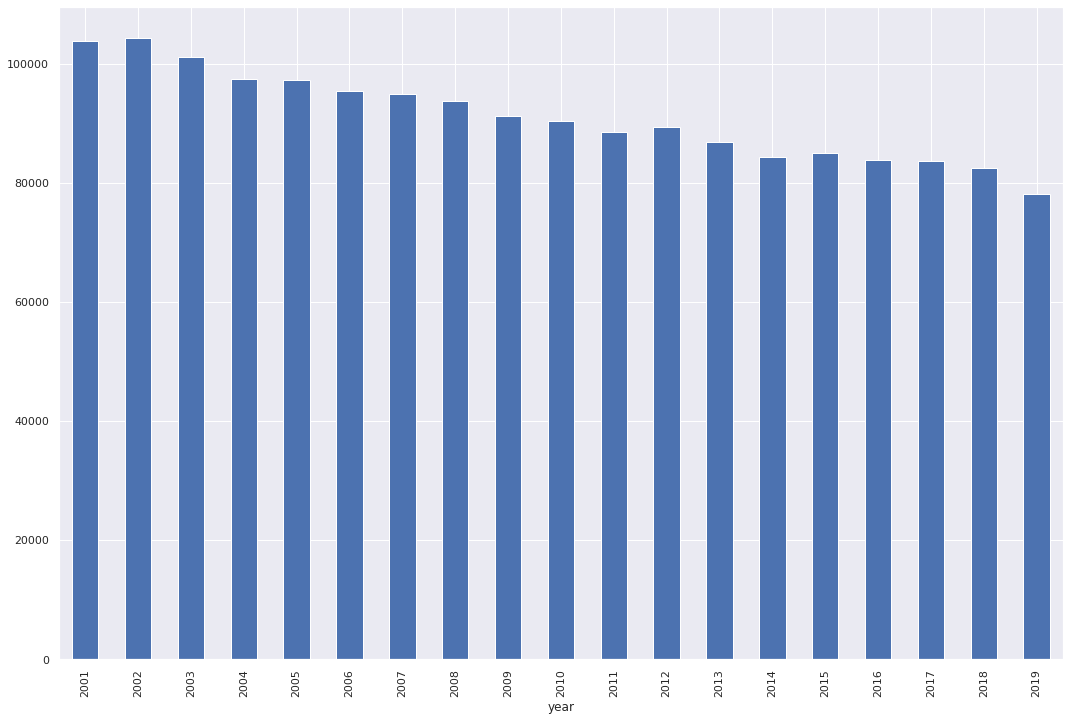

In [20]:
age_adjusted_deaths.plot(kind='bar',figsize=(18,12))

In [21]:
life_expectancy = median_age_of_death

years_lost_per_age = pd.Series(range(0,100,5),index=standard_deaths_age_grp.index)
years_lost_per_age = life_expectancy - years_lost_per_age
years_lost_per_age

0        70
1-4      65
5-9      60
10-14    55
15-19    50
20-24    45
25-29    40
30-34    35
35-39    30
40-44    25
45-49    20
50-54    15
55-59    10
60-64     5
65-69     0
70-74    -5
75-79   -10
80-84   -15
85-89   -20
90+     -25
dtype: int64

In [22]:
LYL_per_age = standard_deaths_age_grp.mul(years_lost_per_age,axis=0)
LYL_per_age = LYL_per_age.applymap(lambda x : 0 if x < 0 else x)
LYL_per_age

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,29055.715500,26030.736900,24757.061700,24757.061700,19343.942100,22289.31600,19821.570300,19821.57030,19821.570300,20219.593800,16716.987000,20617.617300,21413.664300,17353.824600,19503.15150,19821.57030,19184.732700,16159.754100,16478.172900
1-4,5449.857400,5449.857400,5736.692000,3728.849800,6023.526600,4876.18820,4876.188200,4015.68440,5736.692000,4302.519000,3728.849800,3728.849800,3155.180600,3155.180600,3728.84980,3728.84980,2868.346000,4015.684400,3442.015200
5-9,2752.895700,2141.141100,2752.895700,2752.895700,3058.773000,2752.89570,2752.895700,1835.26380,2752.895700,1835.263800,2752.895700,2141.141100,1835.263800,2141.141100,2141.14110,2447.01840,1835.263800,1529.386500,1529.386500
10-14,3249.840000,2979.020000,2708.200000,2708.200000,2708.200000,2437.38000,2166.560000,2979.02000,2979.020000,2437.380000,2437.380000,2708.200000,2166.560000,1895.740000,2979.02000,2166.56000,2437.380000,2979.020000,1895.740000
15-19,9428.535000,10371.388500,10685.673000,10057.104000,8171.397000,9742.81950,10057.104000,9114.25050,8485.681500,8485.681500,8799.966000,7542.828000,7542.828000,7542.828000,7228.54350,6285.69000,7542.828000,7857.112500,7542.828000
20-24,14478.387300,14756.817825,13364.665200,15313.678875,13086.234675,13921.52625,13086.234675,13364.66520,12529.373625,12807.804150,12250.943100,11972.512575,11972.512575,12529.373625,12807.80415,10580.35995,11972.512575,13364.665200,12529.373625
25-29,10613.874400,10383.138000,10844.610800,11075.347200,11536.820000,9921.66520,11536.820000,12229.02920,10844.610800,11536.820000,11306.083600,11075.347200,12459.765600,11306.083600,12690.50200,11536.82000,12690.502000,11536.820000,10844.610800
30-34,11386.992400,11183.653250,10166.957500,9760.279200,9963.618350,10166.95750,9760.279200,10980.31410,9760.279200,10166.957500,10776.974950,9963.618350,10573.635800,12607.027300,11183.65325,11793.67070,11183.653250,11183.653250,10166.957500
35-39,15410.817000,13698.504000,14079.018000,13127.733000,13317.990000,13317.99000,12937.476000,11986.19100,13127.733000,10844.649000,11795.934000,12747.219000,12366.705000,10654.392000,11605.67700,12366.70500,12176.448000,11795.934000,11986.191000
40-44,20222.522250,19893.700750,20058.111500,18249.593250,17920.771750,17591.95025,17427.539500,17591.95025,16769.896500,14961.378250,14961.378250,14468.146000,14468.146000,15125.789000,13974.91375,14632.55675,14796.967500,14303.735250,14139.324500


In [23]:
LYL = LYL_per_age.sum()
LYL

year
2001    236141.043725
2002    226265.198575
2003    222754.973425
2004    217421.578775
2005    209717.576350
2006    208273.905650
2007    204210.978525
2008    201152.600300
2009    198562.205925
2010    189633.493125
2011    184908.372875
2012    185049.996025
2013    184574.942075
2014    178625.770050
2015    179776.855000
2016    175746.529950
2017    174554.741800
2018    170670.800875
2019    162197.449400
dtype: float64

<AxesSubplot:xlabel='year'>

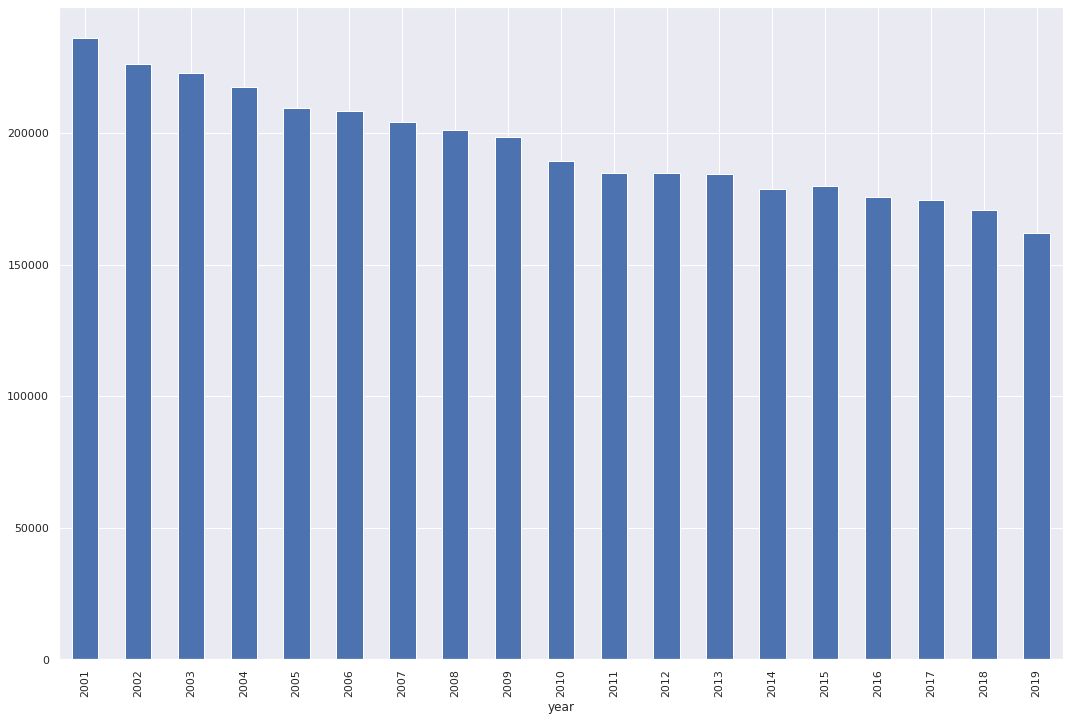

In [24]:
LYL.plot(kind='bar',figsize=(18,12))

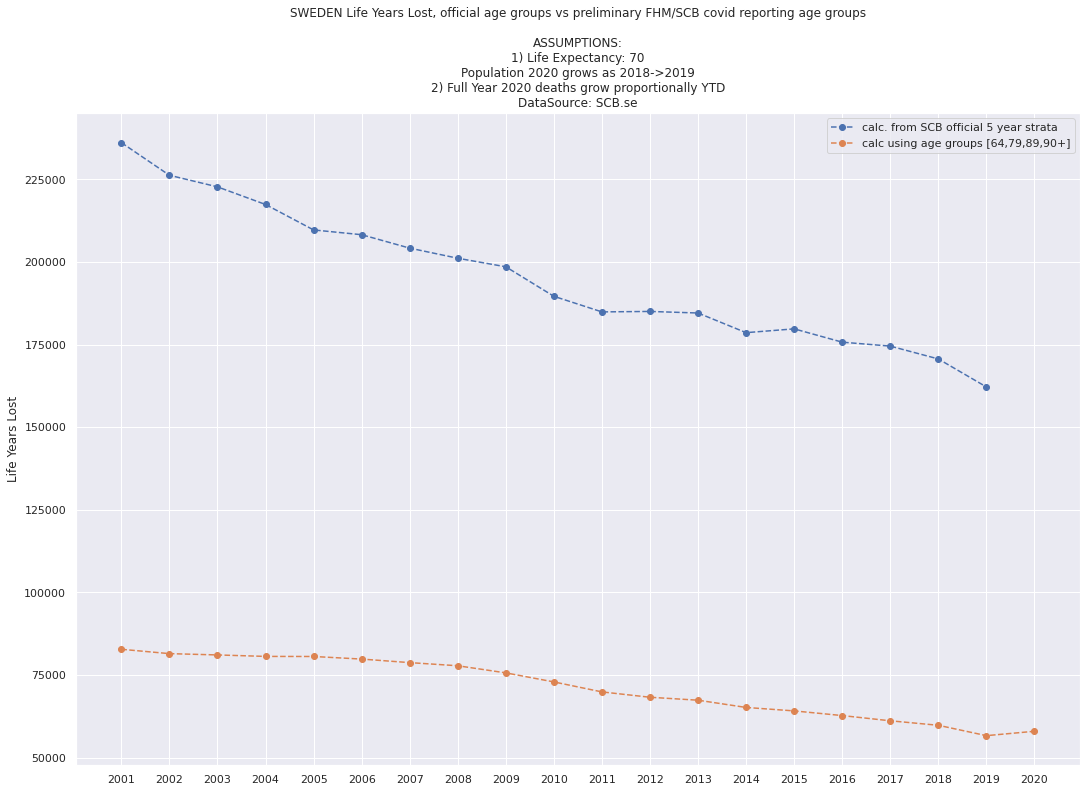

In [25]:
plt.figure(figsize=(18,12))
title = 'SWEDEN Life Years Lost, official age groups vs preliminary FHM/SCB covid reporting age groups\n\n' \
'ASSUMPTIONS:\n1) Life Expectancy: {}\nPopulation 2020 grows as 2018->2019\n2)'.format(life_expectancy) + \
' Full Year 2020 deaths grow proportionally YTD\n' \
'DataSource: SCB.se'

plt.title(title)
plt.plot(LYL,'o--',label='calc. from SCB official 5 year strata')
plt.plot(LYL_total,'o--',label='calc using age groups [64,79,89,90+]')
_= plt.xticks(LYL_total.index)
plt.ylabel('Life Years Lost')

plt.legend(loc='upper right')

In [26]:
lyls = pd.concat([LYL,LYL_total],axis=1)
lyls.columns=['LYL_SCB','LYL__COVID_prel']
lyls

,LYL_SCB,LYL__COVID_prel
year,,
2001,236141.043725,82796.962859
2002,226265.198575,81480.669389
2003,222754.973425,81085.243240
2004,217421.578775,80639.713500
2005,209717.576350,80614.775216
2006,208273.905650,79833.574250
2007,204210.978525,78762.179589
2008,201152.600300,77811.117845
2009,198562.205925,75654.975702


In [27]:
lyls.corr()

,LYL_SCB,LYL__COVID_prel
LYL_SCB,1.00000,0.95328
LYL__COVID_prel,0.95328,1.00000


In [28]:
# manipulate mortality for the young 

mortality_fake = scb_mortality.copy()
mortality_fake.loc['1-4' : '25-29',2019] = scb_mortality.loc['1-4' : '25-29',2019] * 2
mortality_fake

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0.00365,0.00327,0.00311,0.00311,0.00243,0.00280,0.00249,0.00249,0.00249,0.00254,0.00210,0.00259,0.00269,0.00218,0.00245,0.00249,0.00241,0.00203,0.00207
1-4,0.00019,0.00019,0.00020,0.00013,0.00021,0.00017,0.00017,0.00014,0.00020,0.00015,0.00013,0.00013,0.00011,0.00011,0.00013,0.00013,0.00010,0.00014,0.00024
5-9,0.00009,0.00007,0.00009,0.00009,0.00010,0.00009,0.00009,0.00006,0.00009,0.00006,0.00009,0.00007,0.00006,0.00007,0.00007,0.00008,0.00006,0.00005,0.00010
10-14,0.00012,0.00011,0.00010,0.00010,0.00010,0.00009,0.00008,0.00011,0.00011,0.00009,0.00009,0.00010,0.00008,0.00007,0.00011,0.00008,0.00009,0.00011,0.00014
15-19,0.00030,0.00033,0.00034,0.00032,0.00026,0.00031,0.00032,0.00029,0.00027,0.00027,0.00028,0.00024,0.00024,0.00024,0.00023,0.00020,0.00024,0.00025,0.00048
20-24,0.00052,0.00053,0.00048,0.00055,0.00047,0.00050,0.00047,0.00048,0.00045,0.00046,0.00044,0.00043,0.00043,0.00045,0.00046,0.00038,0.00043,0.00048,0.00090
25-29,0.00046,0.00045,0.00047,0.00048,0.00050,0.00043,0.00050,0.00053,0.00047,0.00050,0.00049,0.00048,0.00054,0.00049,0.00055,0.00050,0.00055,0.00050,0.00094
30-34,0.00056,0.00055,0.00050,0.00048,0.00049,0.00050,0.00048,0.00054,0.00048,0.00050,0.00053,0.00049,0.00052,0.00062,0.00055,0.00058,0.00055,0.00055,0.00050
35-39,0.00081,0.00072,0.00074,0.00069,0.00070,0.00070,0.00068,0.00063,0.00069,0.00057,0.00062,0.00067,0.00065,0.00056,0.00061,0.00065,0.00064,0.00062,0.00063
40-44,0.00123,0.00121,0.00122,0.00111,0.00109,0.00107,0.00106,0.00107,0.00102,0.00091,0.00091,0.00088,0.00088,0.00092,0.00085,0.00089,0.00090,0.00087,0.00086


In [29]:
fake_pop_adj_per_grp = mortality_fake.mul(standard_population,axis=0)
fake_pop_adj_per_grp

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,415.081650,371.867670,353.672310,353.672310,276.342030,318.418800,283.165290,283.165290,283.165290,288.851340,238.814100,294.537390,305.909490,247.911780,278.616450,283.165290,274.067610,230.853630,235.402470
1-4,83.843960,83.843960,88.256800,57.366920,92.669640,75.018280,75.018280,61.779760,88.256800,66.192600,57.366920,57.366920,48.541240,48.541240,57.366920,57.366920,44.128400,61.779760,105.908160
5-9,45.881595,35.685685,45.881595,45.881595,50.979550,45.881595,45.881595,30.587730,45.881595,30.587730,45.881595,35.685685,30.587730,35.685685,35.685685,40.783640,30.587730,25.489775,50.979550
10-14,59.088000,54.164000,49.240000,49.240000,49.240000,44.316000,39.392000,54.164000,54.164000,44.316000,44.316000,49.240000,39.392000,34.468000,54.164000,39.392000,44.316000,54.164000,68.936000
15-19,188.570700,207.427770,213.713460,201.142080,163.427940,194.856390,201.142080,182.285010,169.713630,169.713630,175.999320,150.856560,150.856560,150.856560,144.570870,125.713800,150.856560,157.142250,301.713120
20-24,321.741940,327.929285,296.992560,340.303975,290.805215,309.367250,290.805215,296.992560,278.430525,284.617870,272.243180,266.055835,266.055835,278.430525,284.617870,235.119110,266.055835,296.992560,556.861050
25-29,265.346860,259.578450,271.115270,276.883680,288.420500,248.041630,288.420500,305.725730,271.115270,288.420500,282.652090,276.883680,311.494140,282.652090,317.262550,288.420500,317.262550,288.420500,542.230540
30-34,325.342640,319.532950,290.484500,278.865120,284.674810,290.484500,278.865120,313.723260,278.865120,290.484500,307.913570,284.674810,302.103880,360.200780,319.532950,336.962020,319.532950,319.532950,290.484500
35-39,513.693900,456.616800,469.300600,437.591100,443.933000,443.933000,431.249200,399.539700,437.591100,361.488300,393.197800,424.907300,412.223500,355.146400,386.855900,412.223500,405.881600,393.197800,399.539700
40-44,808.900890,795.748030,802.324460,729.983730,716.830870,703.678010,697.101580,703.678010,670.795860,598.455130,598.455130,578.725840,578.725840,605.031560,558.996550,585.302270,591.878700,572.149410,565.572980


In [30]:
fake_pop_adj_per_grp.sum()

year
2001    103909.245535
2002    104379.075000
2003    101178.774795
2004     97454.830905
2005     97434.579435
2006     95539.540795
2007     95081.794705
2008     93845.233440
2009     91376.714305
2010     90482.835325
2011     88543.691780
2012     89436.505670
2013     86946.760160
2014     84413.725270
2015     85043.089185
2016     83876.280370
2017     83692.020615
2018     82646.893875
2019     78982.263365
dtype: float64

In [31]:
LYL_fake = fake_pop_adj_per_grp.mul(years_lost_per_age,axis=0)
LYL_fake = LYL_fake.applymap(lambda x : 0 if x < 0 else x)
LYL_fake

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,29055.715500,26030.736900,24757.061700,24757.061700,19343.942100,22289.31600,19821.570300,19821.57030,19821.570300,20219.593800,16716.987000,20617.617300,21413.664300,17353.824600,19503.15150,19821.57030,19184.732700,16159.754100,16478.172900
1-4,5449.857400,5449.857400,5736.692000,3728.849800,6023.526600,4876.18820,4876.188200,4015.68440,5736.692000,4302.519000,3728.849800,3728.849800,3155.180600,3155.180600,3728.84980,3728.84980,2868.346000,4015.684400,6884.030400
5-9,2752.895700,2141.141100,2752.895700,2752.895700,3058.773000,2752.89570,2752.895700,1835.26380,2752.895700,1835.263800,2752.895700,2141.141100,1835.263800,2141.141100,2141.14110,2447.01840,1835.263800,1529.386500,3058.773000
10-14,3249.840000,2979.020000,2708.200000,2708.200000,2708.200000,2437.38000,2166.560000,2979.02000,2979.020000,2437.380000,2437.380000,2708.200000,2166.560000,1895.740000,2979.02000,2166.56000,2437.380000,2979.020000,3791.480000
15-19,9428.535000,10371.388500,10685.673000,10057.104000,8171.397000,9742.81950,10057.104000,9114.25050,8485.681500,8485.681500,8799.966000,7542.828000,7542.828000,7542.828000,7228.54350,6285.69000,7542.828000,7857.112500,15085.656000
20-24,14478.387300,14756.817825,13364.665200,15313.678875,13086.234675,13921.52625,13086.234675,13364.66520,12529.373625,12807.804150,12250.943100,11972.512575,11972.512575,12529.373625,12807.80415,10580.35995,11972.512575,13364.665200,25058.747250
25-29,10613.874400,10383.138000,10844.610800,11075.347200,11536.820000,9921.66520,11536.820000,12229.02920,10844.610800,11536.820000,11306.083600,11075.347200,12459.765600,11306.083600,12690.50200,11536.82000,12690.502000,11536.820000,21689.221600
30-34,11386.992400,11183.653250,10166.957500,9760.279200,9963.618350,10166.95750,9760.279200,10980.31410,9760.279200,10166.957500,10776.974950,9963.618350,10573.635800,12607.027300,11183.65325,11793.67070,11183.653250,11183.653250,10166.957500
35-39,15410.817000,13698.504000,14079.018000,13127.733000,13317.990000,13317.99000,12937.476000,11986.19100,13127.733000,10844.649000,11795.934000,12747.219000,12366.705000,10654.392000,11605.67700,12366.70500,12176.448000,11795.934000,11986.191000
40-44,20222.522250,19893.700750,20058.111500,18249.593250,17920.771750,17591.95025,17427.539500,17591.95025,16769.896500,14961.378250,14961.378250,14468.146000,14468.146000,15125.789000,13974.91375,14632.55675,14796.967500,14303.735250,14139.324500


In [32]:
LYL_fake_tot = LYL_fake.sum()
LYL_fake_tot

year
2001    236141.043725
2002    226265.198575
2003    222754.973425
2004    217421.578775
2005    209717.576350
2006    208273.905650
2007    204210.978525
2008    201152.600300
2009    198562.205925
2010    189633.493125
2011    184908.372875
2012    185049.996025
2013    184574.942075
2014    178625.770050
2015    179776.855000
2016    175746.529950
2017    174554.741800
2018    170670.800875
2019    199981.403525
dtype: float64

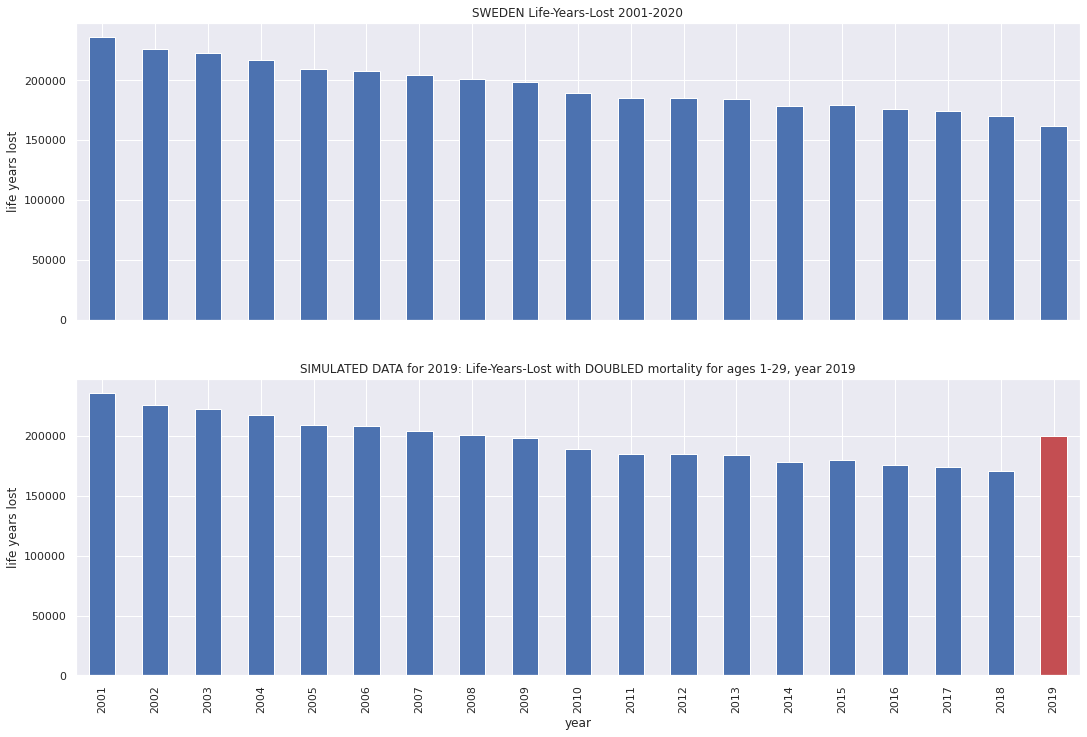

In [33]:
colors = ['b'] * 18
colors.append('r')

fig,axes = plt.subplots(2,1,sharex=True,sharey=True,figsize=(18,12))

LYL.plot(kind='bar',ax=axes[0],title='SWEDEN Life-Years-Lost 2001-2020')

LYL_fake_tot.plot(kind='bar',color=colors,ax=axes[1],
                  title='SIMULATED DATA for 2019: Life-Years-Lost with DOUBLED mortality for ages 1-29, year 2019')

axes[0].set_ylabel('life years lost')
axes[1].set_ylabel('life years lost')

plt.savefig('LYL_simulated_double_mortality_1_29.jpg',format='jpg',dpi=400)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
       [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
       [ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36]])

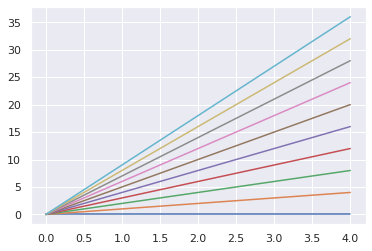

In [34]:

x = np.arange(5)
c = np.arange(10)
_= plt.plot(x,x[:,np.newaxis]*c)
x[:,np.newaxis]*c
